# **백테스트(과거 매매 정보를 통한 투자 시뮬레이션)**
#### <mark>'stock_info.json' 파일을 먼저 준비할 것(1분봉 정보 330개를 포함한 json 파일)<mark/>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

### 1) 데이터 불러오기 & 데이터 변환하기

In [2]:
# 파일 열기
data = None
with open('stock_info(sample).json', 'r') as f:
    data = json.load(f)

# Series 객체 생성
stock_df = pd.DataFrame(data)
stock_price_ser = stock_df['stck_prpr'].astype(int)

### 2) 이동 평균선 계산 및 시각화

In [3]:
# 이동 평균선 계산 (SMA20, SMA60)
sma20 = stock_price_ser.rolling(window=20).mean().fillna(0)
sma60 = stock_price_ser.rolling(window=60).mean().fillna(0)
sma60

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
           ...     
325    17944.166667
326    17951.000000
327    17949.166667
328    17943.833333
329    17939.333333
Name: stck_prpr, Length: 330, dtype: float64

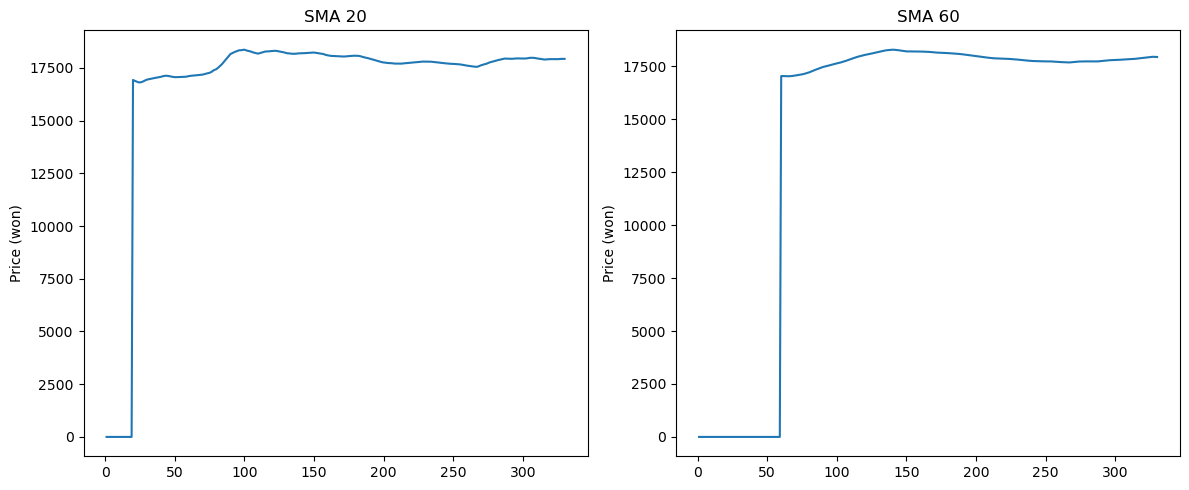

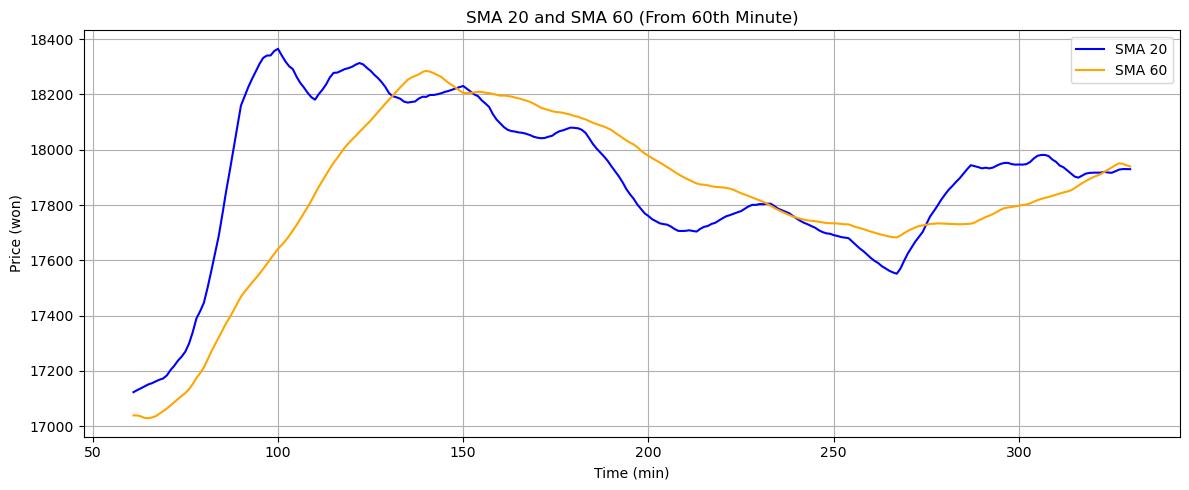

In [4]:
# 시각화

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 위치
plt.plot(range(1, 331), sma20)
plt.title('SMA 20')
plt.ylabel('Price (won)')

plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 위치
plt.plot(range(1, 331), sma60)
plt.title('SMA 60')
plt.ylabel('Price (won)')

plt.tight_layout()
plt.show()

start_index = 60
plt.figure(figsize=(12, 5))
plt.plot(range(start_index + 1, len(sma20) + 1), sma20[start_index:], label='SMA 20', color='blue')
plt.plot(range(start_index + 1, len(sma60) + 1), sma60[start_index:], label='SMA 60', color='orange')
plt.title('SMA 20 and SMA 60 (From 60th Minute)')
plt.xlabel('Time (min)')
plt.ylabel('Price (won)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### 3) 투자 전략 및 백테스트

#### 3-1) 투자 전략
- 잔고 = 10000000 (1천만원)
- 초기수량 = 0
- 골든크로스(SMA20이 SMA60를 상향돌파하는 지점)에서 전량 매수
- 데드크로스(SMA20이 SMA60를 상향돌파하는 지점)에서 전량 매각
- 분봉 데이터가 있는 시점까지 계속해서  수행

#### 3-2) 백테스트

In [5]:
# 초기 설정
잔고 = 10000000  # 1천만 원
수량 = 0

# 매매 기록 저장
매매_기록 = []

# 백테스트 실행
for i in range(1, len(stock_price_ser)):
    # 이전과 현재 이동 평균선 차이 계산
    prev = sma20[i-1] - sma60[i-1]
    current = sma20[i] - sma60[i]

    if prev < 0 and current >= 0:
        # 매수 신호 (SMA20이 SMA60을 상향 돌파)
        if 잔고 > 0:
            수량 = 잔고 // stock_price_ser[i]
            잔고 -= 수량 * stock_price_ser[i]
            매매_기록.append({
                '시점': stock_df['stck_bsop_date'][i],
                '매매': '매수',
                '가격': stock_price_ser[i],
                '수량': 수량,
                '잔고': 잔고,
                '총 자산': 잔고 + 수량 * stock_price_ser[i]
            })

    elif prev >= 0 and current < 0:
        # 매도 신호 (SMA20이 SMA60을 하향 돌파)
        if 수량 > 0:
            잔고 += 수량 * stock_price_ser[i]
            매매_기록.append({
                '시점': stock_df['stck_bsop_date'][i],
                '매매': '매도',
                '가격': stock_price_ser[i],
                '수량': 수량,
                '잔고': 잔고,
                '총 자산': 잔고
            })
            수량 = 0  # 매도 후 수량은 0

# 최종 자산 출력
최종_자산 = 잔고 + 수량 * stock_price_ser.iloc[-1]
print(f"최종 자산: {최종_자산}원")

최종 자산: 9950730원


### 4) 매매기록 내보내기

In [6]:
# 매매 기록을 데이터프레임으로 변환하여 출력
매매_기록_df = pd.DataFrame(매매_기록)
print(매매_기록_df)

# 매매 기록을 CSV 파일로 저장
매매_기록_df.to_csv('매매_기록.csv', index=False)

         시점  매매     가격   수량       잔고      총 자산
0  20240425  매수  18180  550     1000  10000000
1  20240425  매도  18060  550  9934000   9934000
2  20240425  매수  17730  560     5200   9934000
3  20240425  매도  17750  560  9945200   9945200
4  20240425  매수  17980  553     2260   9945200
5  20240425  매도  17990  553  9950730   9950730
